In [1]:
from models.resnet18_unet import *
from collections import defaultdict
import torch.nn.functional as F
from utils.dataloader import CrackConcrete, CrackConcreteData
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import argparse
import torch.utils.data as data
import torch.nn as nn
import time
import datetime
import math
import shutil
from tqdm import trange
from torchvision.ops import nms
import tqdm
from torch.utils.tensorboard import SummaryWriter
from utils.loss import *
from torch.optim import lr_scheduler
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils.helper import *

In [2]:

trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
device = "cuda"
model = ResNetUNet(1)
model.load_state_dict(torch.load("logs/test1/checkpoint_0.pth"))
model = model.to(device)

model.eval()   # Set model to the evaluation mode
print("Model is Loaded")

Model is Loaded


In [3]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

torch.Size([7, 3, 192, 192])


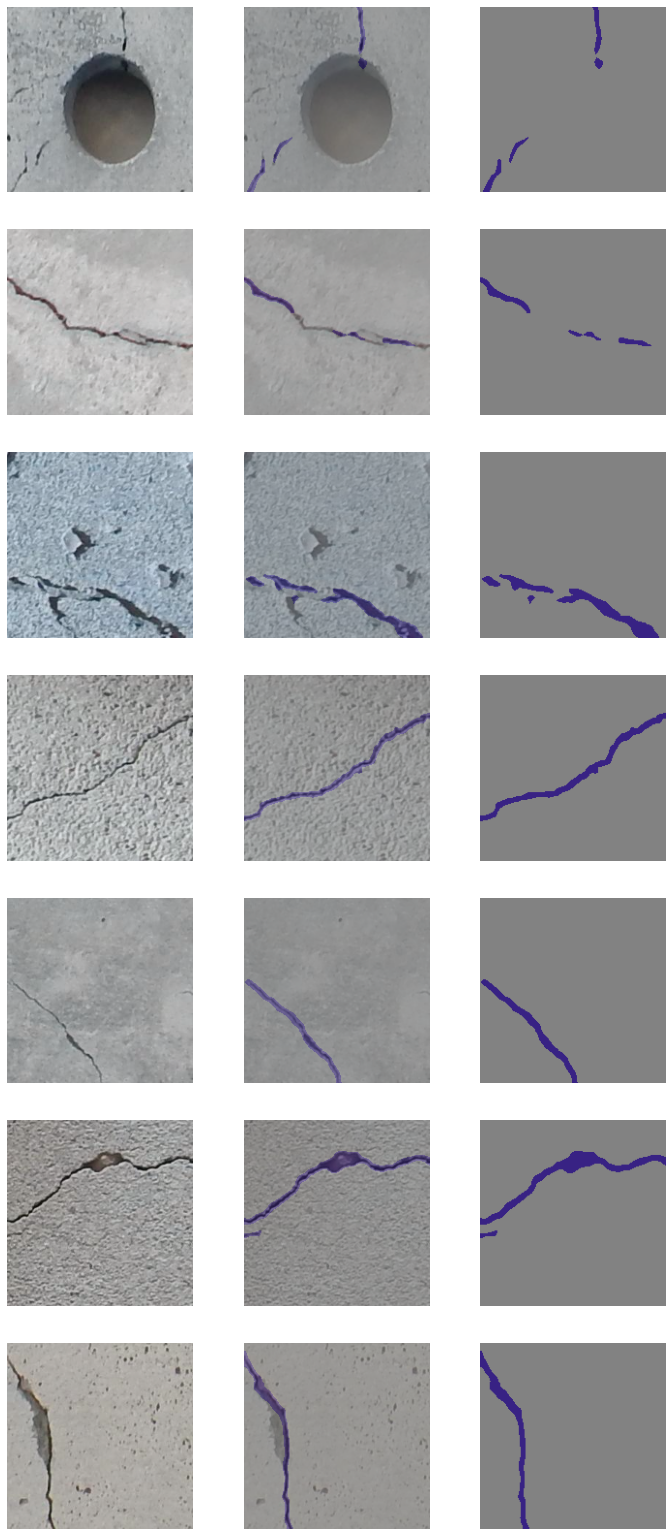

In [4]:
# Create another simulation dataset for test
images = "/media/syn/7CC4B2EE04A2CEAE/Thesis/Classification/ClassificationData/benchmark"
images_data = []
for im in os.listdir(images):
    img = cv2.resize(cv2.imread(os.path.join(images,im)),(192,192))
    images_data.append(trans(img).unsqueeze(0).cuda())

images_data = torch.cat(images_data,dim= 0)
print(images_data.shape)
pred = model(images_data)
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()

input_images_rgb = [reverse_transform(x) for x in images_data.cpu()]
colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])[4:5]
pred_rgb = [masks_to_colorimg(x,colors) for x in pred]
blending_masks = [cv2.addWeighted(y, 0.5, x, 0.5, 0) for x,y in zip(input_images_rgb,pred_rgb)]
plot_side_by_side([input_images_rgb, blending_masks,pred_rgb])


In [33]:
input_img = trans(img)
inputs = input_img.unsqueeze(0).cuda()



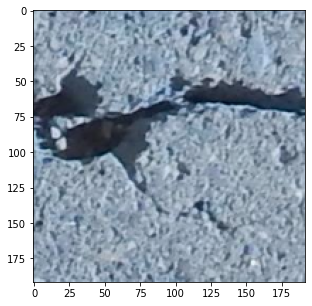

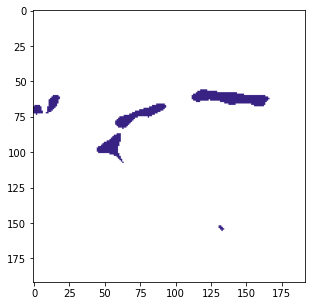

In [34]:


plt.figure(figsize = (10,5))
plt.imshow(input_images_rgb[0])
plt.figure(figsize = (10,5))
plt.imshow(pred_rgb[0])

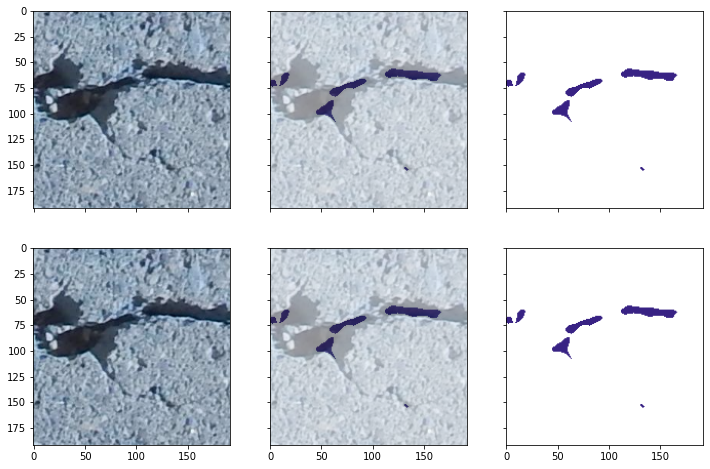

In [46]:
input_img = trans(img)
inputs = input_img.unsqueeze(0).cuda()
inputs = torch.cat([inputs,inputs],dim=0)
pred = model(inputs)
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])[4:5]
pred_rgb = [masks_to_colorimg(x,colors) for x in pred]
blending_masks = [cv2.addWeighted(y, 0.5, x, 0.5, 0) for x,y in zip(input_images_rgb,pred_rgb)]
plot_side_by_side([input_images_rgb, blending_masks,pred_rgb])